## Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

## Define Functions

In [2]:
# define evaluation function
def evaluate(y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    
    print("Accuracy:    ", accuracy)
    print("F1-Score:    ", f1)
    print("Precision:   ", precision)
    print("Recall:      ", recall)
    print()
    print(classification_report(y_test, y_pred))
    print()

    disp.plot()

## Load .csv into DF

In [3]:
# load data into dataframe
df = pd.read_csv("phishing_email_projectthesis.csv") 

## Prepare Data

In [4]:
# rename columns
df = df.rename(columns={'text_combined': 'content'}).rename(columns={'label': 'target'}) 

In [5]:
# drop duplicates but keep the first
df = df.drop_duplicates(keep='first') 

In [6]:
# randomized undersampling
df = df.groupby('target').apply(lambda x: x.sample(39233, replace=True, random_state=42)).reset_index(drop=True)

/var/folders/gr/nkq2fp191y1_3wywjp14_sz00000gn/T/ipykernel_1722/842751370.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('target').apply(lambda x: x.sample(39233, replace=True, random_state=42)).reset_index(drop=True)


## Split Data into Training and Test 80-20

In [7]:
# define X and Y
X = df['content']
y = df['target']

# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check the shape
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (62772,)
Shape of X_test: (15694,)
Shape of y_train: (62772,)
Shape of y_test: (15694,)


## Vektorize with TF-IDF

In [8]:
# creating vectorizer object with standart parameters
vectorizer = TfidfVectorizer()

# fit on and tranform training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# transform test data 
X_test_tfidf = vectorizer.transform(X_test)

## Multi Layer Perceptron

/Users/nikobiebl/.local/share/virtualenvs/Project-Thesis-PGQKRxl5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:     0.9961131642665987
F1-Score:     0.9961064658198762
Precision:    0.9954075774971297
Recall:       0.9968063362289218

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7866
           1       1.00      1.00      1.00      7828

    accuracy                           1.00     15694
   macro avg       1.00      1.00      1.00     15694
weighted avg       1.00      1.00      1.00     15694




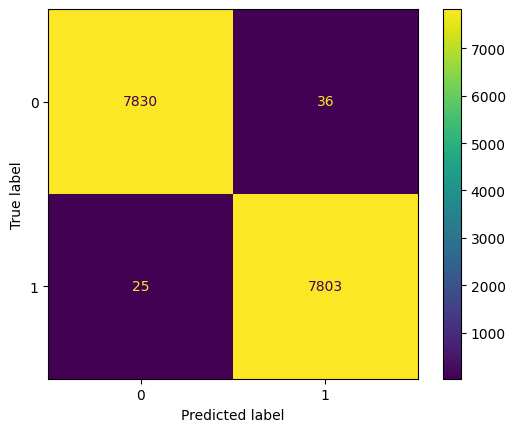

In [9]:
# create classifier object
mlp_tfidf_classifier = MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=1,random_state=42)

# train classifier
mlp_tfidf_classifier.fit(X_train_tfidf, y_train)

# test classifier
mlp_tfidf_predictions = mlp_tfidf_classifier.predict(X_test_tfidf)

# evaluate
evaluate(mlp_tfidf_predictions)

## Creating Treshold Evaluation

In [10]:
probabilities = mlp_tfidf_classifier.predict_proba(X_test_tfidf)

probabilities_0 = probabilities[:, 0]
probabilities_1 = probabilities[:, 1]

actual_values = y_test

probabilities_and_values_df = pd.DataFrame({
    'probabilities_0': probabilities_0,
    'probabilities_1': probabilities_1,
    'actual_values': actual_values
})

print(probabilities_and_values_df.shape)
print(probabilities_and_values_df.head(20))

(15694, 3)
       probabilities_0  probabilities_1  actual_values
30578         0.999976         0.000024              0
75285         0.000101         0.999899              1
47368         0.002449         0.997551              1
23969         0.999976         0.000024              0
53099         0.001621         0.998379              1
14076         0.999653         0.000347              0
20565         0.999278         0.000722              0
62974         0.001488         0.998512              1
55285         0.000114         0.999886              1
61165         0.000343         0.999657              1
49031         0.001067         0.998933              1
65834         0.000722         0.999278              1
64319         0.000949         0.999051              1
63695         0.000039         0.999961              1
77050         0.000246         0.999754              1
15197         0.999774         0.000226              0
9908          0.999954         0.000046              0

In [11]:
under_60_percent_df = probabilities_and_values_df[(probabilities_and_values_df['probabilities_0'] < 0.6) & (probabilities_and_values_df['probabilities_1'] < 0.60)]

print(under_60_percent_df.shape)
print(under_60_percent_df.head(22))

(21, 3)
       probabilities_0  probabilities_1  actual_values
54700         0.411216         0.588784              1
30282         0.588090         0.411910              0
18138         0.443169         0.556831              0
689           0.467704         0.532296              0
53020         0.508569         0.491431              1
68196         0.483448         0.516552              1
56850         0.462655         0.537345              1
10684         0.539202         0.460798              0
28171         0.557635         0.442365              0
62644         0.497556         0.502444              1
52007         0.423012         0.576988              1
28092         0.496202         0.503798              0
36718         0.475109         0.524891              0
18969         0.554363         0.445637              0
54001         0.484908         0.515092              1
25243         0.597426         0.402574              0
10936         0.557635         0.442365              0
61

In [12]:
thresholds = np.arange(0.5, 1.0, 0.01)

results = []

for threshold in thresholds:

    classifiable_df = probabilities_and_values_df[(probabilities_and_values_df['probabilities_0'] > threshold) | (probabilities_and_values_df['probabilities_1'] > threshold)]
    
    percentage_classifiable = (len(classifiable_df) / len(probabilities_and_values_df)) * 100
    
    predicted_labels = np.where(classifiable_df['probabilities_1'] > threshold, 1, 0)

    accuracy = accuracy_score(classifiable_df['actual_values'], predicted_labels) * 100
    precision = precision_score(classifiable_df['actual_values'], predicted_labels) * 100
    recall = recall_score(classifiable_df['actual_values'], predicted_labels) * 100
    f1 = f1_score(classifiable_df['actual_values'], predicted_labels) * 100

    results.append({
        'threshold': threshold,
        'classifiable': percentage_classifiable,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

results_df = pd.DataFrame(results)

print(results_df.head(50))

    threshold  classifiable   accuracy  precision     recall         f1
0        0.50    100.000000  99.611316  99.540758  99.680634  99.610647
1        0.51     99.974513  99.630338  99.553401  99.706070  99.629677
2        0.52     99.961769  99.630291  99.553287  99.705995  99.629582
3        0.53     99.949025  99.642994  99.578705  99.705995  99.642310
4        0.54     99.929910  99.649302  99.591368  99.705958  99.648630
5        0.55     99.929910  99.649302  99.591368  99.705958  99.648630
6        0.56     99.904422  99.655590  99.604087  99.705958  99.654996
7        0.57     99.904422  99.655590  99.604087  99.705958  99.654996
8        0.58     99.898050  99.655568  99.604036  99.705920  99.654952
9        0.59     99.872563  99.655480  99.603884  99.705807  99.654820
10       0.60     99.866191  99.655458  99.603884  99.705807  99.654820
11       0.61     99.866191  99.655458  99.603884  99.705807  99.654820
12       0.62     99.853447  99.668177  99.629346  99.705807  99